In [1]:
import sys
import os
sys.path.append(os.getcwd())

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
from tqdm import tqdm
import trimesh
import open3d as o3d
import yaml
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from copy import deepcopy
import mesh2sdf

import polyscope as ps

import torch

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from src.mesh_io import trimesh_to_o3d, normalize_mesh_with_transform, bbox_normalize_points
from src.utils import print_tensor, find_objects, get_render, get_prim_mesh_path
from src.visu import visu_sdf_slice_img, visu_sdf_slice_contour, PolyscopeSession
from src.sdf_warping import FourierWarpField, warp_sdf_grid, extract_mesh_marching_cubes

# Setup

In [4]:
DATA_DIR_GT = Path("data/gt_meshes/20251024_092559-gt_meshes-02-pipeline_LN_encoderFrozen/segmented_meshes")
DATA_DIR_GEN = Path("data/gen_meshes/20251113_104750-gen_meshes-06-pipeline_85kredundant/segmented_meshes")

sha_list_gt = find_objects(DATA_DIR_GT)
print(f"Found {len(sha_list_gt)} objects in {DATA_DIR_GT}")
sha_list_gen = find_objects(DATA_DIR_GEN)
print(f"Found {len(sha_list_gen)} objects in {DATA_DIR_GEN}")
assert set(sha_list_gt) == set(sha_list_gen), "GT and GEN object sets do not match!"
sha_list = sha_list_gt
del sha_list_gt, sha_list_gen

Found 100 objects in data\gt_meshes\20251024_092559-gt_meshes-02-pipeline_LN_encoderFrozen\segmented_meshes
Found 100 objects in data\gen_meshes\20251113_104750-gen_meshes-06-pipeline_85kredundant\segmented_meshes


# Load a mesh  
e.g. f4559de0f094665cc80f9df90f60f5654c5cfad1595a94ac2f95e7f74b295e35

Analyzing object a1b260f45eb1e425d83b9bf78686dcce2999c5832eaf41b51211929ea89b0b9a


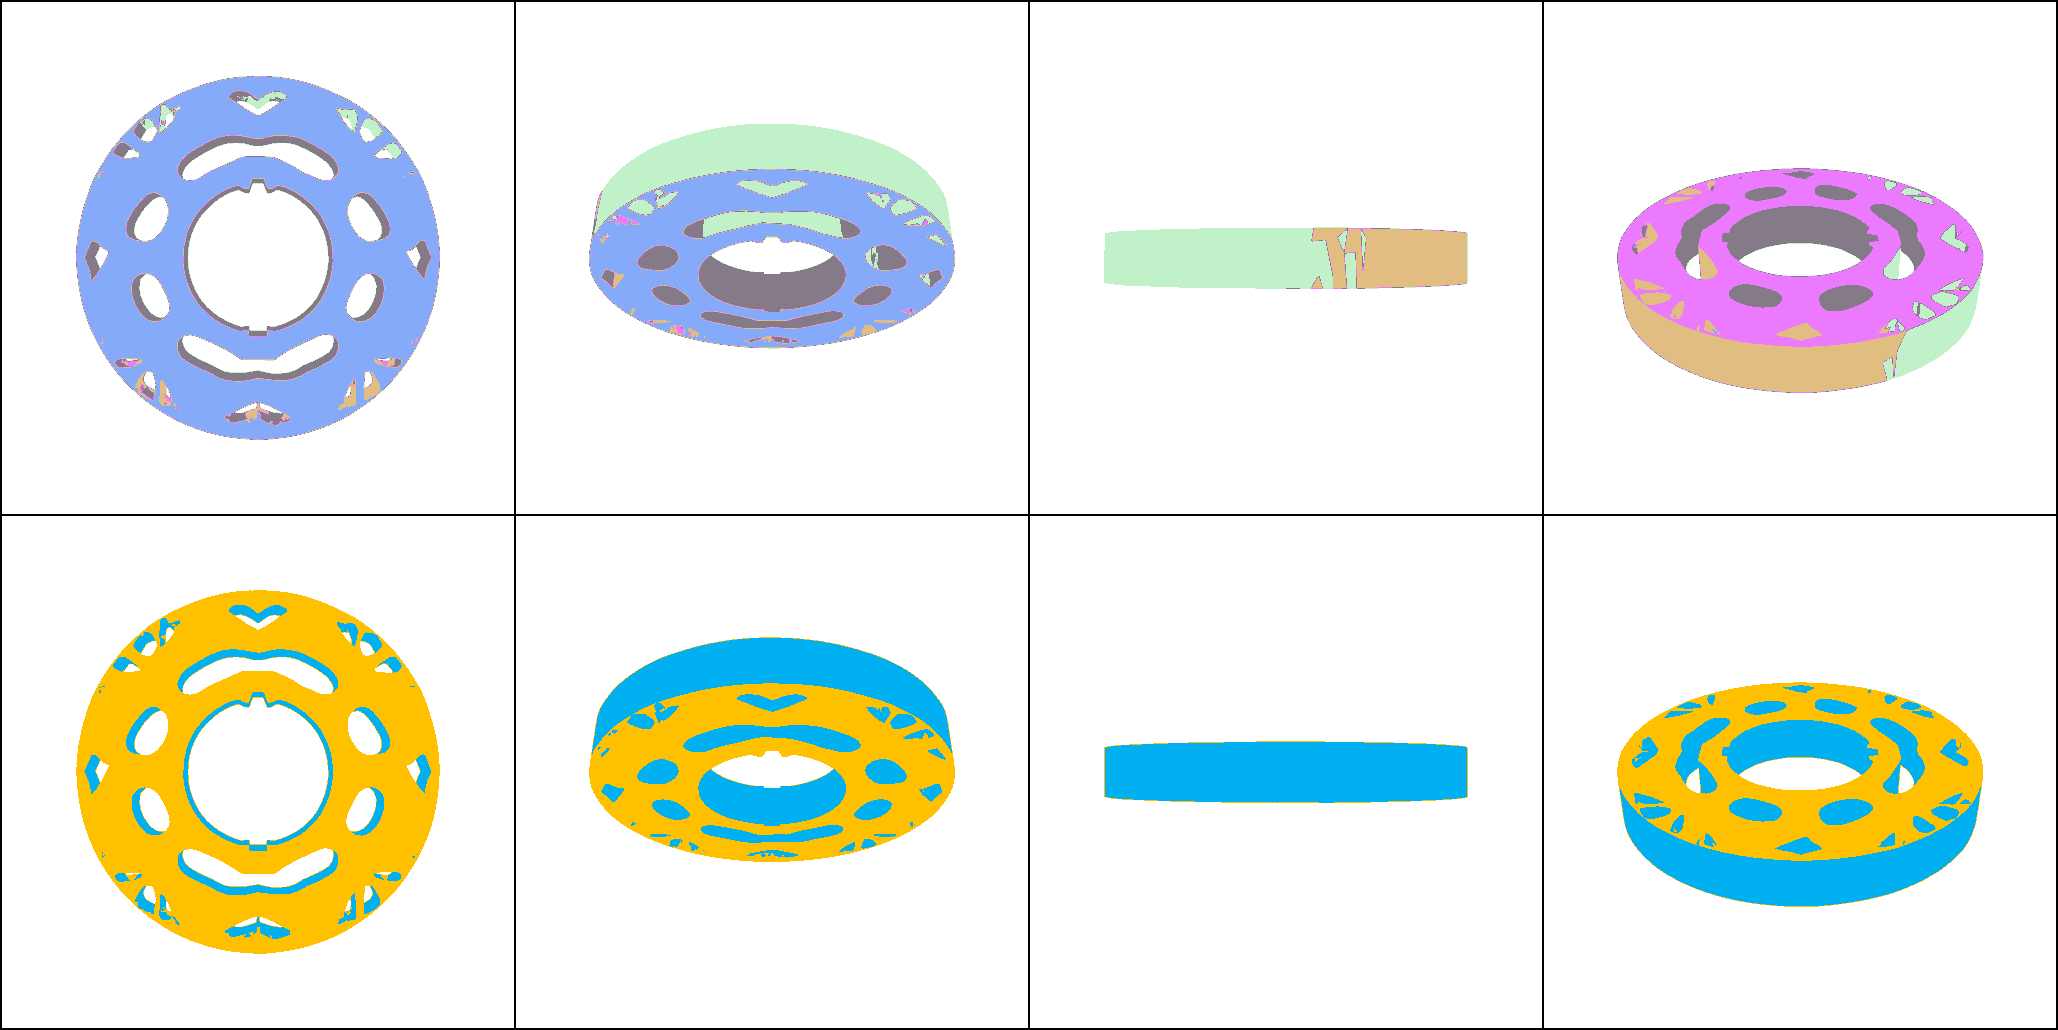

In [40]:
sha = np.random.choice(sha_list)
print(f"Analyzing object {sha}")
get_render(sha)

In [6]:
# sha = "f4559de0f094665cc80f9df90f60f5654c5cfad1595a94ac2f95e7f74b295e35"
# version = 'gt'

# mesh = o3d.io.read_triangle_mesh(str(get_prim_mesh_path(sha, version=version)))
# mesh, _, _ = normalize_mesh_with_transform(mesh)


# # o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)

## Compute SDF

In [ ]:
sha = 'a1b260f45eb1e425d83b9bf78686dcce2999c5832eaf41b51211929ea89b0b9a'
mesh_scale = 1.0
size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
level = 2 / size

# load mesh
mesh_path = str(get_prim_mesh_path(sha, version='gt'))
mesh = trimesh.load(mesh_path, force='mesh')
assert mesh.is_watertight, "the negative value of SDF is not reliable if the mesh is not watertight"
V = mesh.vertices
F = mesh.faces

# normalize vertices to fit in bbox
Vn = bbox_normalize_points(V, mesh_scale)
print_tensor(Vn, "Vn after normalization")

cache_dir = Path("data/sdf_cache")
cache_dir.mkdir(parents=True, exist_ok=True)
cache_path = cache_dir / f"{sha}_sdf_r{size}_meshscale{mesh_scale}.npz"
if os.path.exists(cache_path):
	print(f"Loading cached SDF grid from {cache_path}")
	data = np.load(cache_path)
	phi = data['sdf']
else:
	print(f"Computing SDF grid ({size}^3) for mesh {sha}...")
	# phi = mesh2sdf.compute(Vn, F, size, fix=False,) # inside it calls mesh2sdf.core.compute with potential fix
	phi = mesh2sdf.core.compute(Vn, F, size)
	
	np.savez_compressed(cache_path, sdf=phi)
	print(f"SDF grid saved to {cache_path}")

phi = torch.from_numpy(phi).float()[None, None].to(device)

Vn after normalization : (992, 3), min : -0.500, max : 0.500, mean : -0.000, std : 0.211
Computing SDF grid (128^3) for mesh a1b260f45eb1e425d83b9bf78686dcce2999c5832eaf41b51211929ea89b0b9a...
SDF grid saved to data\sdf_cache\a1b260f45eb1e425d83b9bf78686dcce2999c5832eaf41b51211929ea89b0b9a_sdf_r128_meshscale1.0.npz


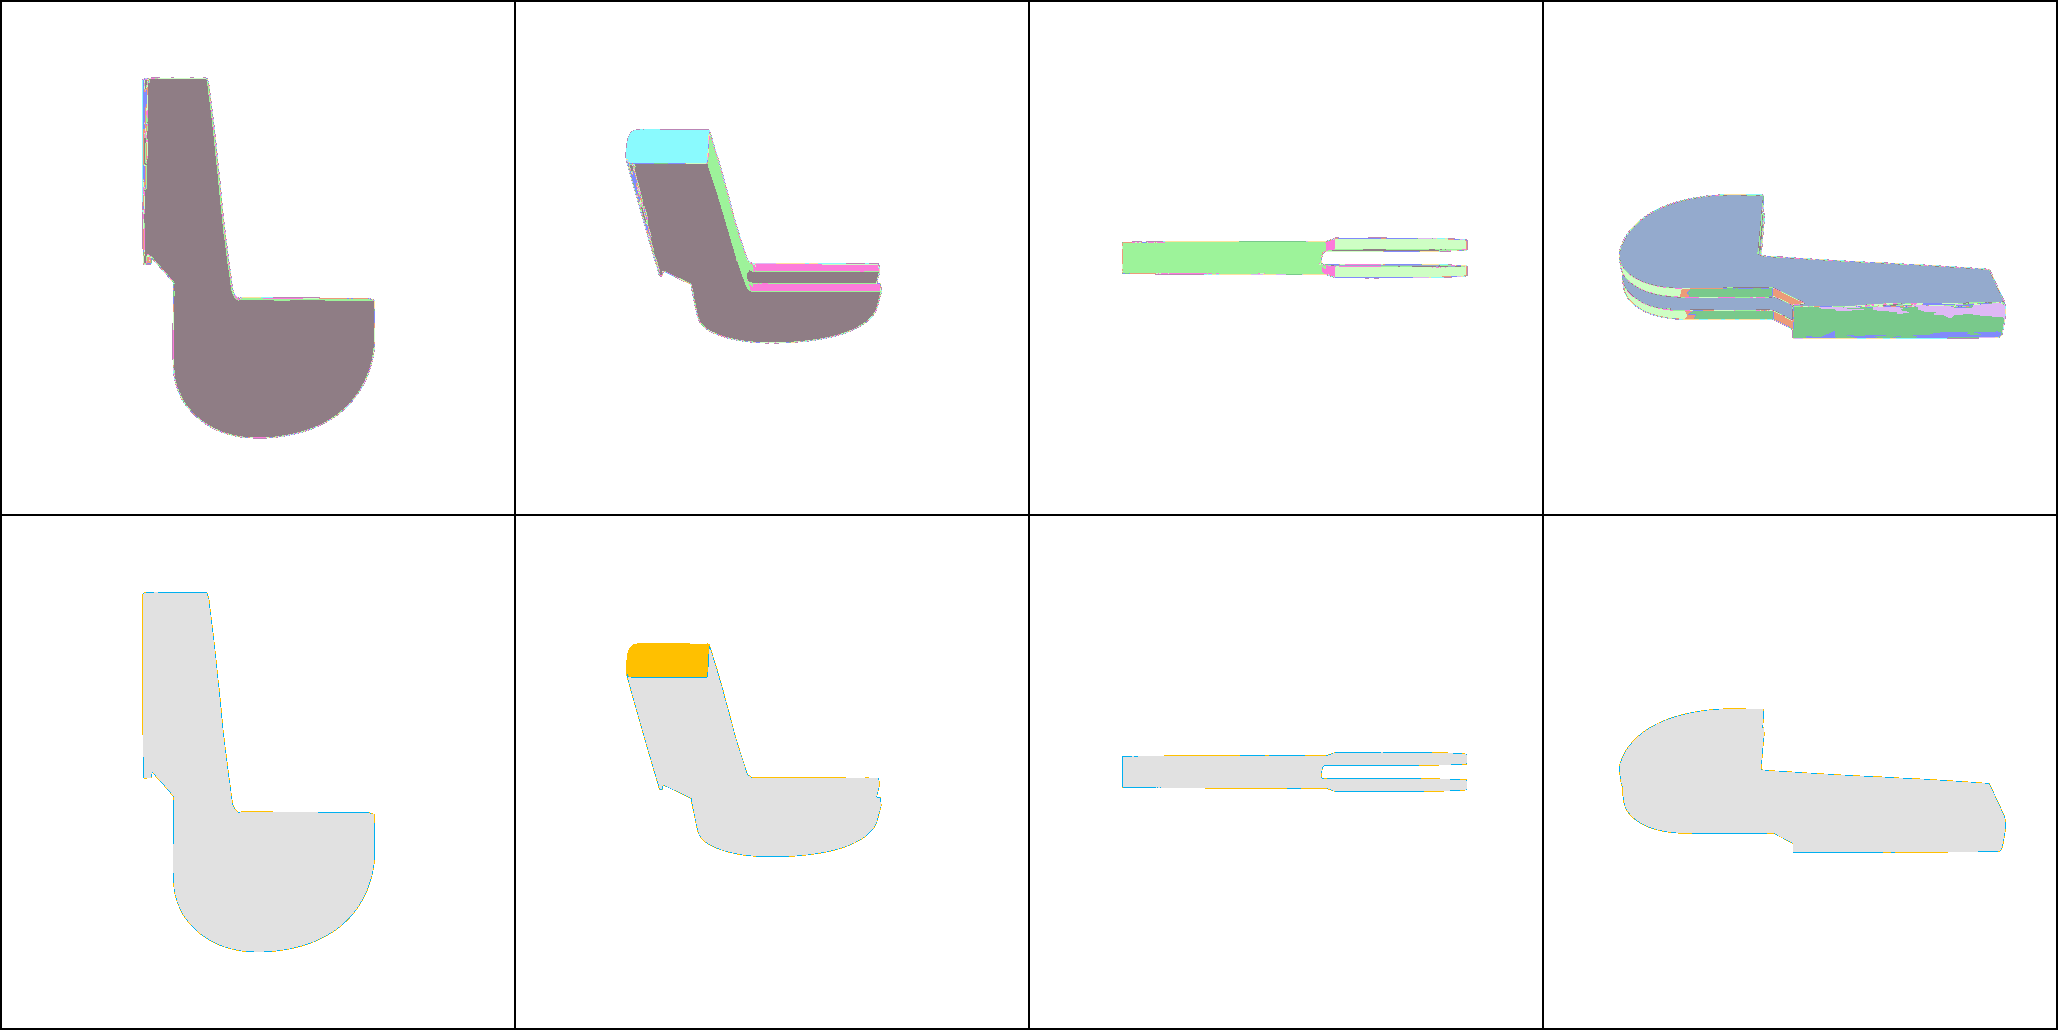

In [24]:
get_render(sha)

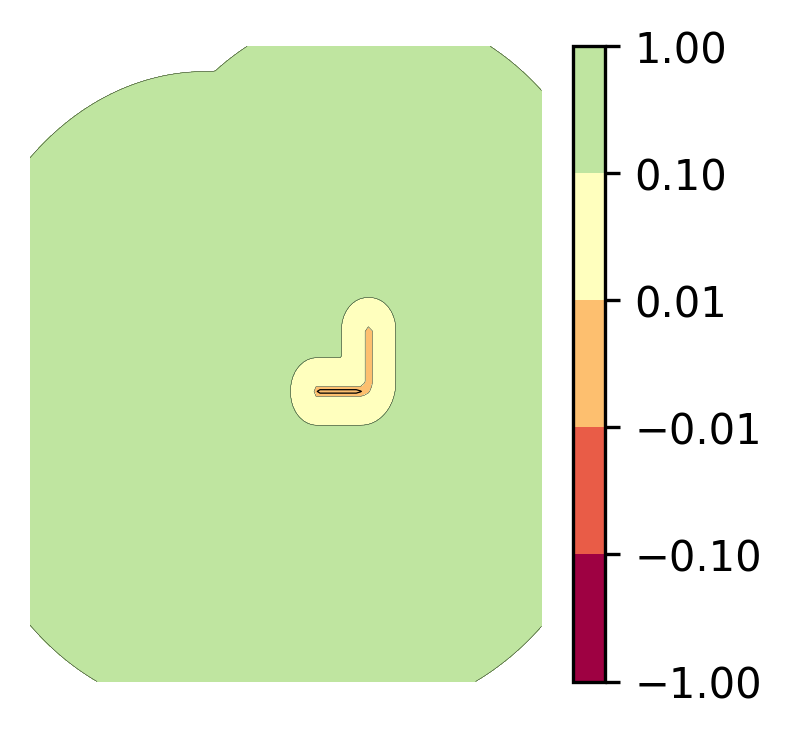

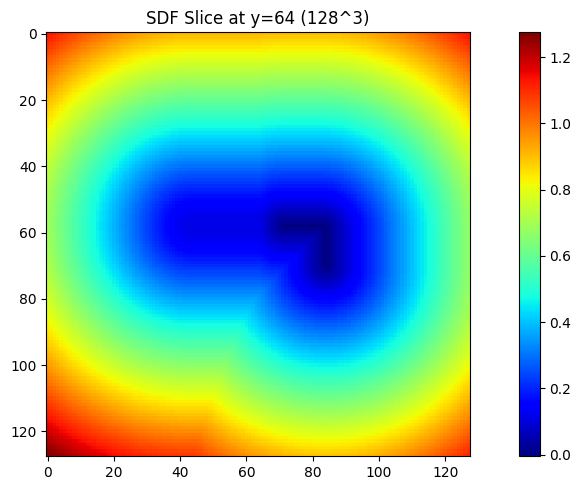

In [27]:
axis = 'y'
slice_ix = 64

ax = visu_sdf_slice_contour(sdf=phi.squeeze().cpu().numpy(), axis=axis, slice_ix=slice_ix)

ax = visu_sdf_slice_img(sdf=phi.squeeze().cpu().numpy(), axis=axis, slice_ix=slice_ix)
                            
plt.tight_layout()
plt.show()

## SDF Warping

In [28]:
bbox_min_norm = torch.tensor([-mesh_scale]*3, device=device)
bbox_max_norm = torch.tensor([ mesh_scale]*3, device=device)

warp = FourierWarpField(modes=(5,5,5), amplitude=0.01, seed=0, device=device)

phi_warp = warp_sdf_grid(phi, warp, bbox_min_norm, bbox_max_norm)
print_tensor(phi_warp, 'phi_warp')

phi_warp             : torch.Size([1, 1, 128, 128, 128]), min : -0.005, max : 1.656, mean : 0.679, std : 0.279


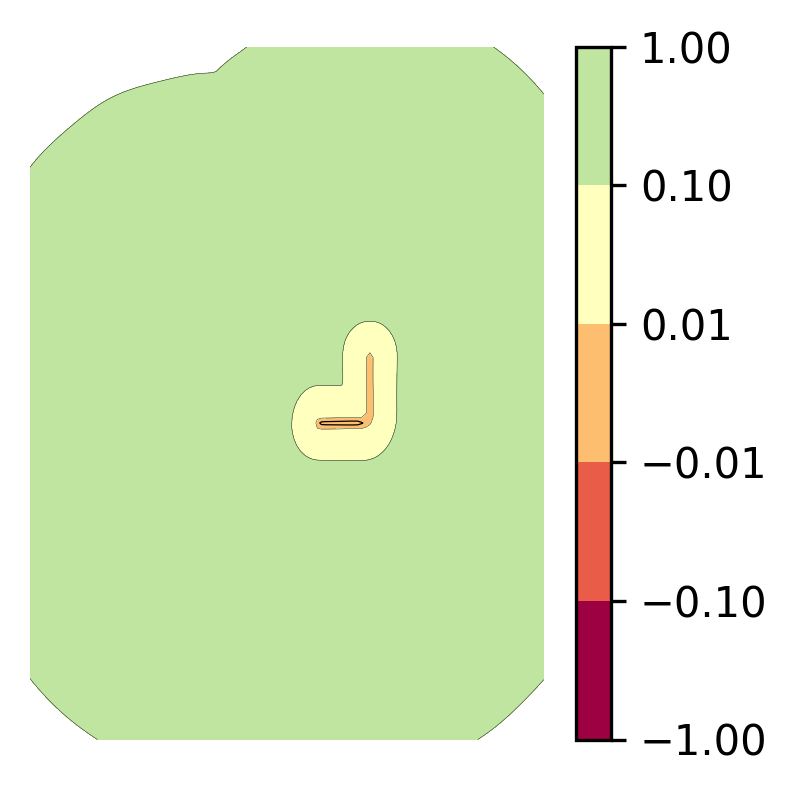

In [31]:
axis = 'y'
slice_ix = 64
ax = visu_sdf_slice_contour(phi_warp.squeeze().detach().cpu().numpy(), axis, slice_ix)
plt.tight_layout()
plt.show()

## Mesh extraction

In [36]:
# Extract mesh
warped_verts, warped_faces = extract_mesh_marching_cubes(phi_warp, bbox_min_norm, bbox_max_norm)

center = (warped_verts.min(0) + warped_verts.max(0)) * 0.5
scale  = mesh_scale / (warped_verts.max(0) - warped_verts.min(0)).max()
warped_verts = (warped_verts - center) * scale  # normalized vertices

print_tensor(warped_verts, "warped_verts")
print_tensor(warped_faces, "warped_faces")

[DEBUG] verts min/max after mc: [57.63714 32.04324 43.6433 ] [70.328705 95.66321  84.32356 ]
[DEBUG] verts_norm01 min/max : [0.45383573 0.25230896 0.34364802] [0.55376935 0.7532536  0.66396505]
warped_verts         : (3324, 3), min : -0.500, max : 0.500, mean : 0.026, std : 0.216
warped_faces         : (6640, 3), min : 0.000, max : 3323.000, mean : 1663.526, std : 958.846


In [37]:
with PolyscopeSession() as ps_session:
	ps_org_mesh = ps.register_surface_mesh("original normalized mesh", Vn, F)
	ps_warp_mesh = ps.register_surface_mesh("warped mesh", warped_verts, warped_faces)
	ps.show()